# Predicting Sales for Rossmann Stores

### Author: João Brum

The Rossmann Company operates over 3000 drugstores in 7 European countries. Currently, Rossmann Store managers are tasked with forecasting daily sales. Store sales are influenced by many factors, including promotions, competition, school/state holidays, seasonality and location. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Therefore, the Manager Director of Rossmann requested, during a monthly results meeting, the realization of a Sales Forecast project for all stores for the next six weeks, encompassed in a single model. 

#### Why make a sales forecast?
The sales forecasting will be the basis to know what will be the total revenue to be able to invest in store refurbishment. 

#### Solution Format
- Daily Sales Model for the coming weeks.

- Prediction problem (Time Series) 

#### Data Source:
https://www.kaggle.com/c/rossmann-store-sales#

#### Solution Planning:
- Data Description

- Featuring Engineering

- Variable Filter

- Exploratory Data Analysis

- Data Preparation

- Feature Selection

- Machine Learning Models

- Hyperparameter Fine Tuning

- Error Interpretation and Translation


#### Data Dicitionary:

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
from scipy import stats as ss
import random
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.metrics import mean_absolute_error, mean_squared_error


from IPython.display import Image

In [2]:
# Set the style
sns.set_style('whitegrid')

# Set to display an unlimited number of columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None


### 0.1 Helper Functions

In [3]:
# Function that converts camel style to snake style
def camel_to_snake(s):
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [4]:
# Function that measures the association between two categorical variables
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))

    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

In [5]:
# Function to calculate MAE
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)
# Function to calculate MAPE
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))
# Function that calculates MAE, MAPE and RMSE
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

In [6]:
# Function to train the model using cross validation
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # Date that will start the validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

        # Filter the dataset and split it in train and test
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Drop columns for training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        # Drop columns for validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # ML Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error( 'Linear regression', np.expm1(yvalidation), np.expm1(yhat))
    
        # Performance for each metric
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( { 'Model': [model_name],
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])

### 0.2 Loading Data

In [7]:
# Load data
df_sales_raw = pd.read_csv("../data/train.csv", low_memory = False)
df_store_raw = pd.read_csv("../data/store.csv", low_memory = False)

In [8]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
# Merge the store dataframe into sales dataframe
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [11]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.0 Data Description

This section is necessary to know the characteristics of the dataset. It is important to know the range of each variable, its distributions, missing valus, number of examples and data types.

In [12]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [13]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snake_case = lambda x: camel_to_snake(x)

cols_new = list(map(snake_case, cols_old))

df1.columns = cols_new

### 1.2 Data Dimensions

In [14]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


### 1.3 Data Types

In [15]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

Since the dataset has some columns that were read with different types, I need to change it.

In [16]:
df1['date'] = pd.to_datetime(df1['date'])

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Checking missing values 

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fill out NA

All replaces of NaN Values are taking into account the business context. If most variables are not providing a good model, in the second CRISP cycle we can change it to another approach.

**competition_distance**: I am going to consider a distance of 200000 when the register is NaN, it indicates that the store doesn't have a competitor.

**competition_open_since_month**: I am going to consider the "today" month in the register is NaN.

**competition_open_since_year**: I am going to consider the "today" year in the register is NaN.

**promo2_since_week**: I am going to consider the "today" week in the register is NaN.

**promo2_since_year**: I am going to consider the "today" year in the register is NaN.

**promo_interval**: I am going to consider 0 (no interval) when the register is NaN.


In [19]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map ={ 1 : "Jan",2 : "Feb", 3 : "Mar", 4 : "Apr",5 : "May",6 : "Jun", 7 : "Jul",8 : "Aug",9 : "Sep",10 : "Octo",11 : "Nov",12 : "Dec"}

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map(month_map)


# is_promo
df1['is_promo'] = df1[['month_map', 'promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis = 1)




In [20]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


In [21]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6 Change Data Types 

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [23]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)  

### 1.7 Descriptive Statistics 

In [24]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [25]:
# Central tendency - Mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
m.columns = ["Attributes", "Mean", "Median", "Std", "Min", "Max", "Range", "Skew", "Kurtosis"]

In [26]:
m

,Attributes,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


**Observations**:

- Stores are named from 1 to 1115;
- Day of week contains the 7 days of a week;
- Sales variable is a little bit skewed and it has a average sale of 5.8k Euros approximately.;
- Mean of customers is 633 by day, and it indicates is not a normal distribution;
- Open is a binary feature, and most days the stores are opened.
- Promo is a binary feature;
- School holiday is a binary feature;
- Competition features are very skewed and have a lot of kurtosis.
- Promo2 is a binary feature and it starts on 2009 and it's been running until 2015;
- is_promo is a binary feature;

#### 1.7.2 Categorical Attributes

In [27]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

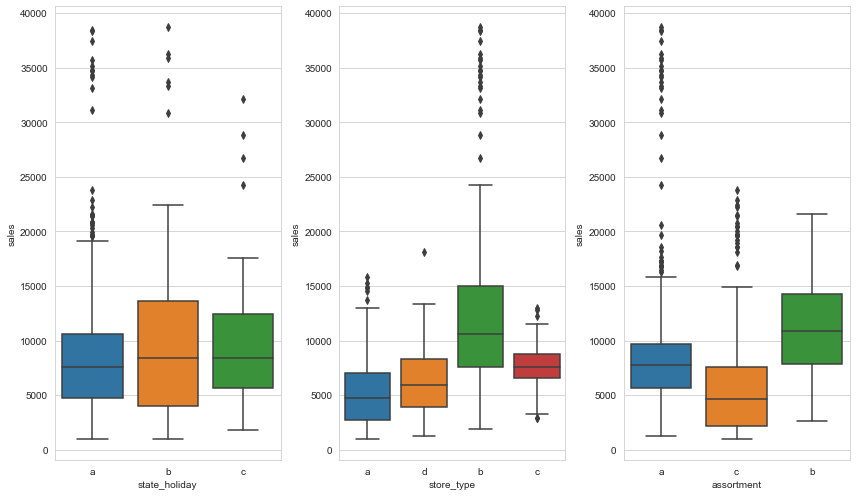

In [28]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(1, figsize = (12,7))

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

plt.tight_layout()



**Observations**:

- State holidays are not relevant for sales;
- Stores of "b" type sell more then others;
- Assortment stores of type "extra" sell more than others.

## 2.0 Feature Engineering

In this section I am considering some hypothesis based on the mental map that is depicted below. The construction of this is considering all the variables that can impact the target variable (Sales). Then, using feature engineering and business knowledge, we can find out some important insights to report to managers.

In [29]:
df2 = df1.copy()

### 2.1 Hypothesis Map

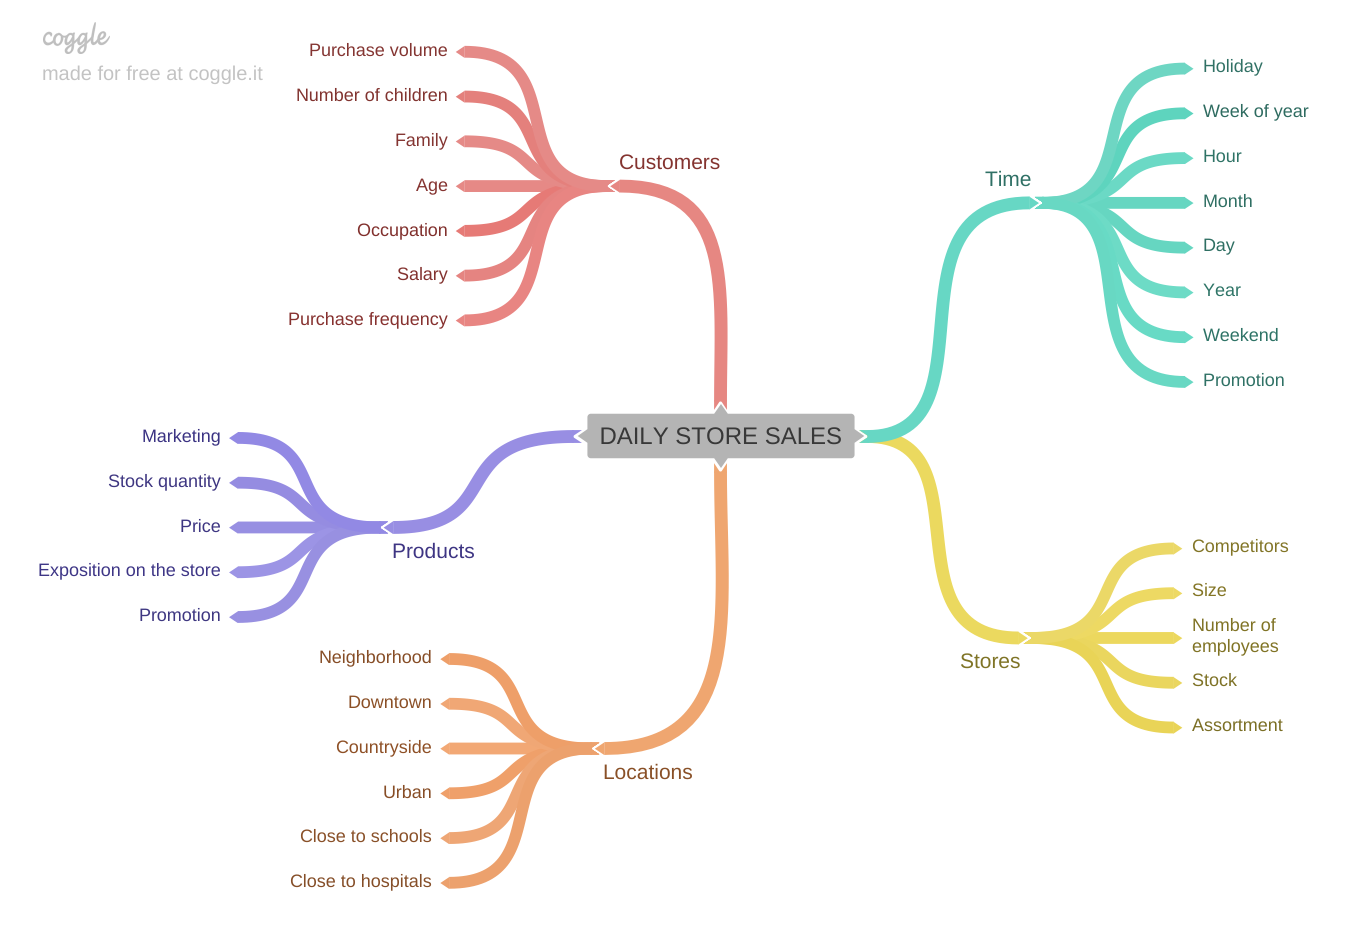

In [30]:
Image('../img/HypothesisMap.png')

### 2.2 Hypothesis Construction

#### 2.2.1 Store Hypothesis

**H1**: Stores with more employees should sell more.

**H2**: Stores with more stock should sell more.

**H3**: Bigger stores should sell more.

**H4**: Smaller stores should sell less.

**H5**: Stores with a larger assortment should sell more.

**H6**: Stores with long-term competitors should sell more.

**H7**: Stores with competitors closer should sell less.

#### 2.2.2 Product Hypothesis

**H1**: Stores that invests more in marketing should sell more.

**H2**: Stores that shows more products in the window should sell more.

**H3**: Stores with lower prices should sell more.

**H4**: Stores with lower prices and longer should sell more.

**H5**: Stores with active promotion longer should sell more.

**H6**: Stores with more dias in promotion should sell more.

**H7**: Stores with more consecutive promotions should sell more.

#### 2.2.3 Time Hypothesis

**H1**: Stores that are in a holiday should sell less.

**H2**: Stores that open in the first 6 months of the year should sell more.

**H3**: Stores that open on the weekend should sell more.

**H4**: Stores that open during the Christimas holiday should sell more.

**H5**: Stores should sell more over the years.

**H6**: Stores should sell more in the 2nd semester of the year.

**H7**: Stores should sell more after the 10th day of the month.

**H8**: Stores should sell less during the school holidays.

### 2.3 List of Valid Hypothesis

**H1**: Stores with a larger assortment should sell more.

**H2**: Stores with long-term competitors should sell more.

**H3**: Stores with competitors closer should sell less.
    
**H4**: Stores with active promotion longer should sell more.

**H5**: Stores with more dias in promotion should sell more.

**H6**: Stores with more consecutive promotions should sell more.
    
**H7**: Stores that open during the Christimas holiday should sell more.

**H8**: Stores should sell more over the years.

**H9**: Stores should sell more in the 2nd semester of the year.

**H10**: Stores should sell more after the 10th day of the month.

**H11**: Stores should sell less during the school holidays.

### 2.4 Feature Engineering

In [31]:
# Extracting the year from date
df2['year'] = df2['date'].dt.year

# Extracting the month from date
df2['month'] = df2['date'].dt.month

# Extracting the day from date
df2['day'] = df2['date'].dt.day

## Extracting the week of year from date
df2['week_of_year'] = df2['date'].dt.weekofyear

# Converting the week of year into YEAR-WEEK
df2['year_week'] = df2['date'].dt.strftime("%Y-%W")

#competition since will join 2 variables into one
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month=x['competition_open_since_month'] , day =1), axis = 1)
# This variable is the number of months since a competition started
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Change the time of promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# Convert the Year-Week of the year to Year-Month-Day
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
# Number of weeks since a promo started
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# Change the name of assortment types for the real names
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
 
# Change the names of state holiday for the real names
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')


C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


## 3.0 Data Filtering

This section is used to filter some variables and examples. Some variables that are not important for the model will be disconsidering at this moment.

In [32]:
df3 = df2.copy()

### 3.1 Row Filtering

In [33]:
# We are going to consider just days when the stores are open and sold items
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Columns Filtering

In [34]:
# Number of Customers is not available for the next 6 weeks in the moment of prediction
# As I've dropped Open !=0, it remains only open = 1. This doesn't represent a information
# Promo interval and Month map was used just to create other features
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis = 1)

**Observations**:
- Number of customers is not available in the moment of forecasting the next 6 weeks. It is possible to use another machine learning model to predict the number of customers in the next 6 weeks and then append the result to this notebook. However, we are just dropping this from the dataset.
- Since I've dropped Open !=0, it remains only Open = 1, and this variable doesn't represent a information.
- Promo interval and Month map were used to create another features and can be dropped.

In [35]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.0 Exploratory Data Analysis (EDA)

This section is used to understand the business and the dataset. It is the most important part to report some useful insights for the managers. To analyze it, I will consider 3 analysis:
- Univariate - The distribution, countplot and boxplot of each variable. It is important to remove outliers further.
- Bivariate - All the hypothesis can be answered in this subsection. It can analyze the impact of each feature in the target variable;
- Multivariate - Important to remove colinearity.

In [36]:
df4 = df3.copy()

### 4.1 Univariate Analysis

#### 4.1.1 Target Variable

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


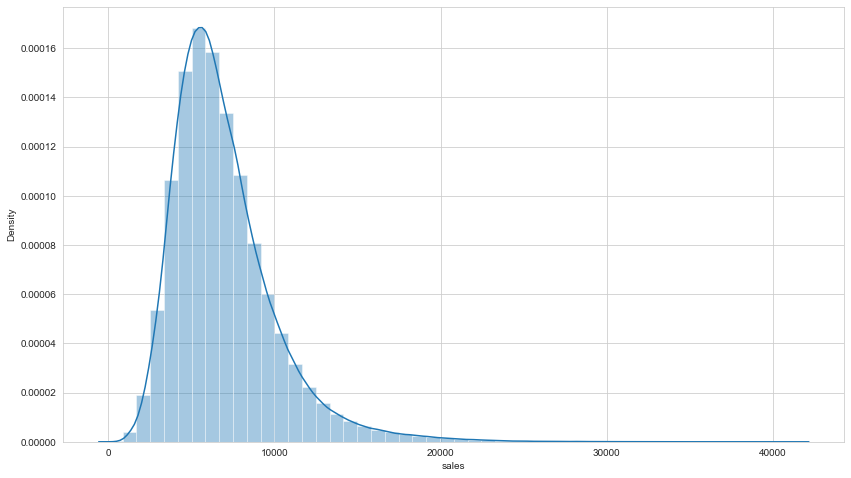

In [37]:
plt.figure(1, figsize = (14,8))
sns.distplot(df4['sales'])

**Observations**:

- Sales variable may follow a normal distribution, but I can't confirm it. Then, it is important to use some techniques in the next sections to make it as a normal dist.

#### 4.1.2 Numerical Variables

In [38]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64', 'int32', 'int64'])

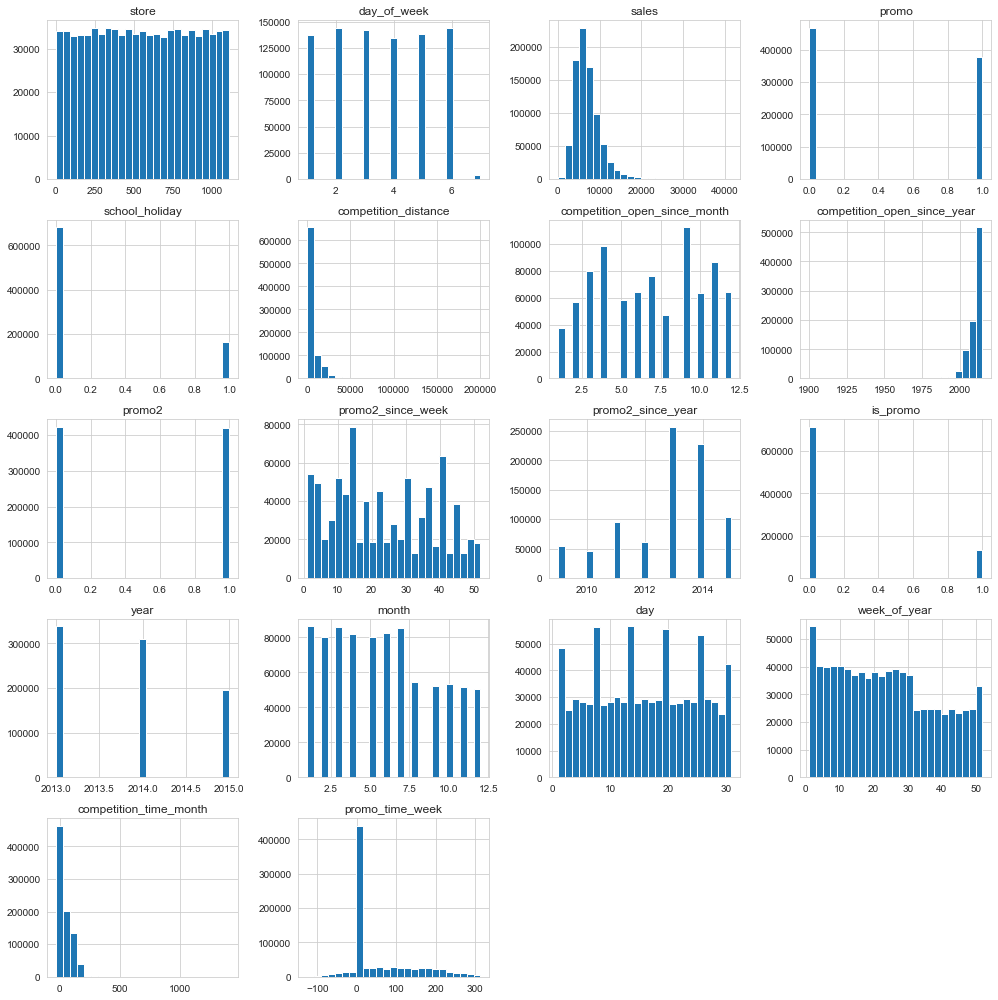

In [39]:
num_attributes.hist(bins = 25, figsize = (14,14))
plt.tight_layout()

**Observations**:

- Analyzing the distributions, no variable follows a normal distribution. 

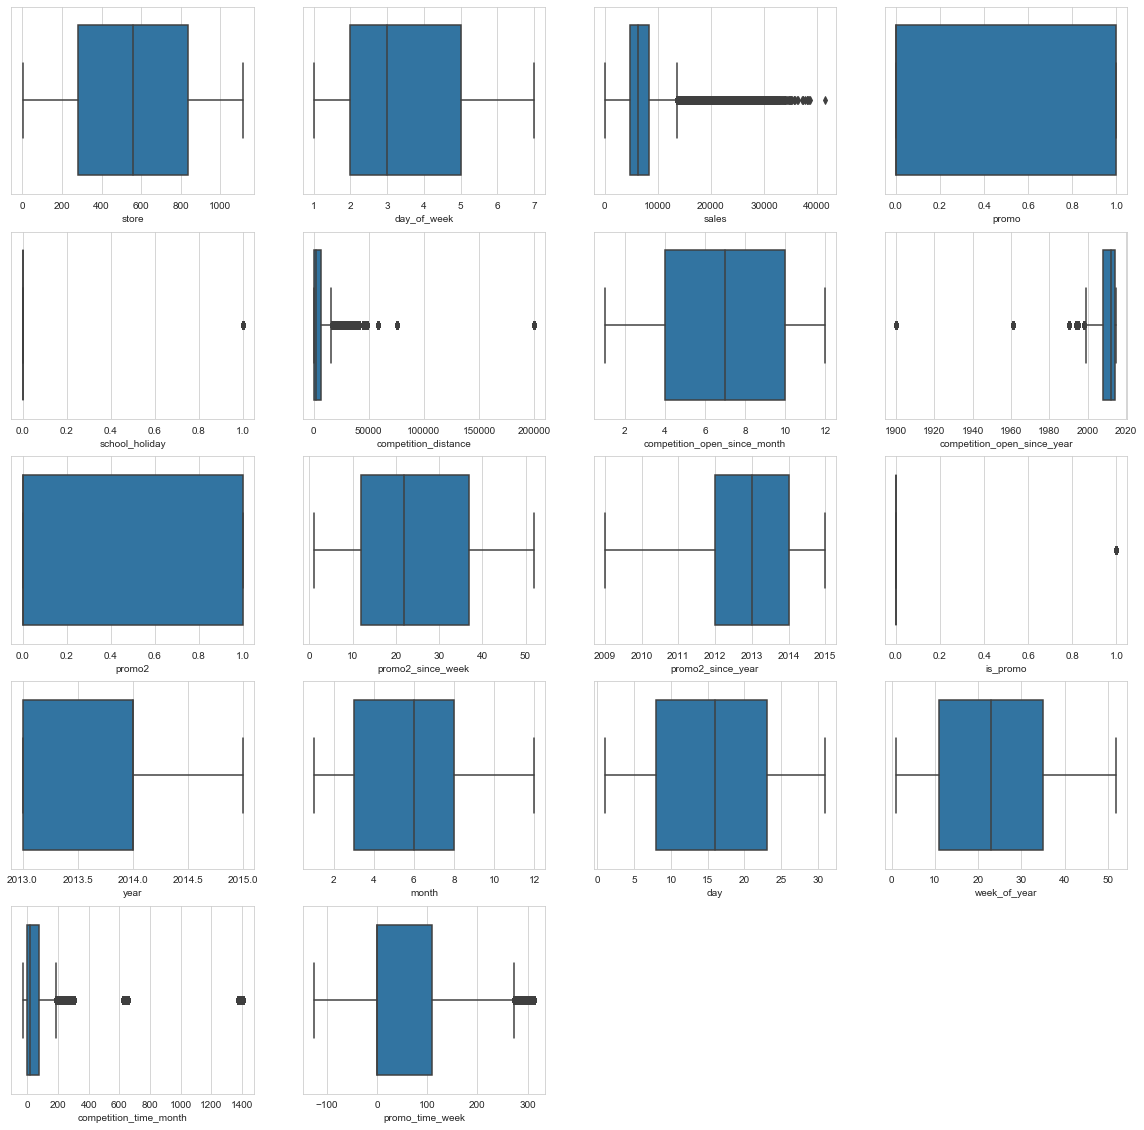

In [40]:
plt.figure(1, figsize = (20,20))
for i, col in enumerate(num_attributes.columns):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x = num_attributes[col])

**Observations**: 
Boxplot is important to analyze the outliers of each variable. In the next sections I need to pay attention on it.

- competition_distance has outliers; 
- competition_open_since_year has outliers;
- competition_time_month has outliers;
- promo_time_week has outliers;



In [41]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [42]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

#### 4.1.3 Categorical Variables

In [43]:
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'int64', 'datetime64[ns]'])

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


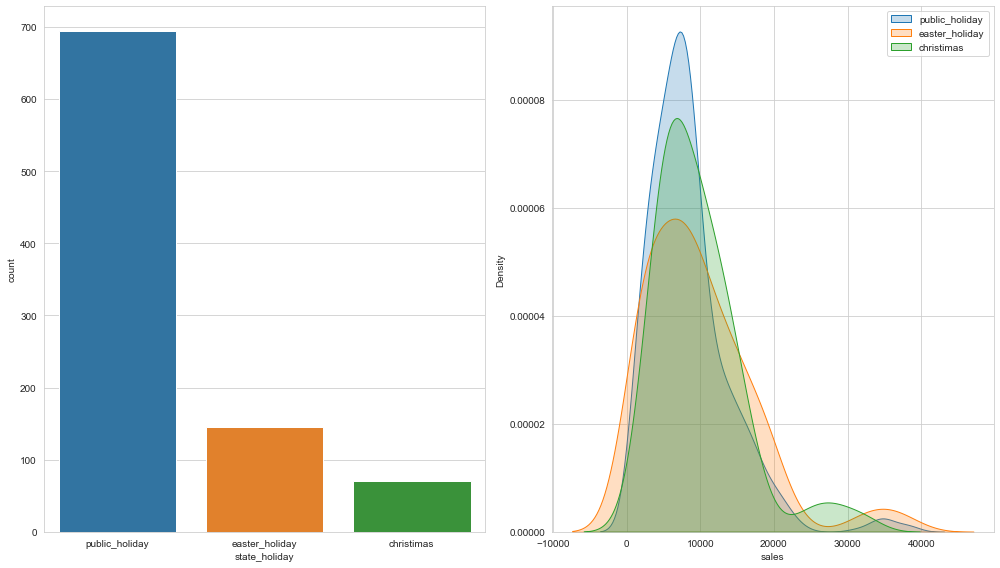

In [45]:
# State holiday
plt.figure(1, figsize=(14,8))
plt.subplot(1, 2, 1)
sns.countplot(aux['state_holiday'])
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.kdeplot(aux[aux['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(aux[aux['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(aux[aux['state_holiday'] == 'christimas']['sales'], label = 'christimas', shade = True)
plt.legend()
plt.tight_layout()

**Observations**:
- Analyzing the state holiday variable, we can see that public_holiday is predominant over the other holidays and the distribution of sales by holiday is well differentiable, it can indicate a good feature for the model.
- Even with less registers, chritmas has a large amount of sales.

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


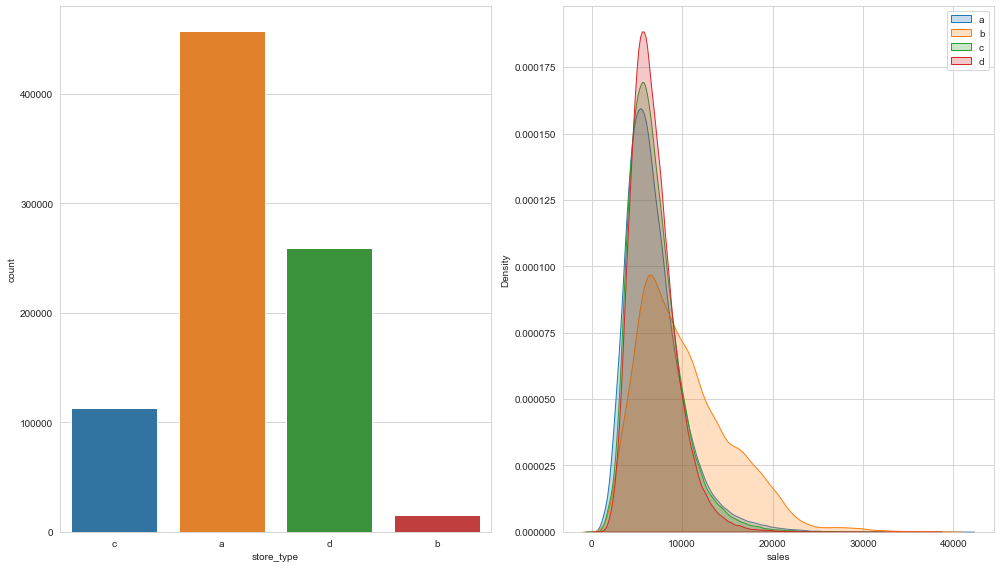

In [46]:
# Store type
plt.figure(1, figsize=(14,8))
plt.subplot(1, 2, 1)
sns.countplot(df4['store_type'])
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)
plt.legend()
plt.tight_layout()

**Observations**:
- Store of type "a" is the most prevalent in the number of records, followed by types "d", "c" and "a".
- Almost all types have the same distribution but "b" is quite different, with more skew and less sales.

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


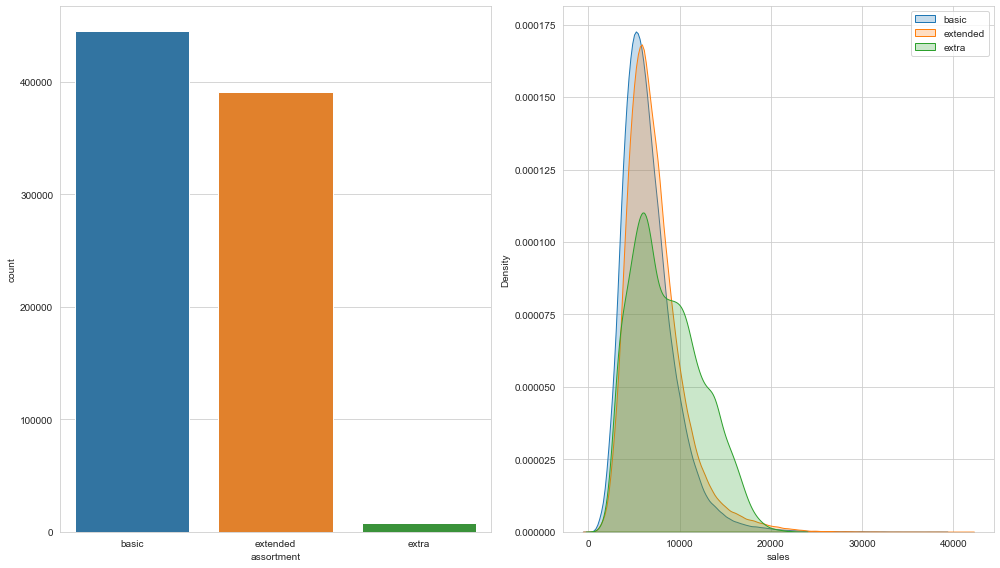

In [47]:
# Assortment
plt.figure(1, figsize=(14,8))
plt.subplot(1, 2, 1)
sns.countplot(df4['assortment'])
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)
plt.legend()
plt.tight_layout()

**Observations**:
- The number of registers for basic and extended assortment is way higher than extra;
- Even with the smaller number of registers, extra has a large amount of sales, but less than others.

### 4.2 Bivariate Analysis

**Important**: As we have seen above, some variables have the number of registers way different between each one. Then, I will consider the number of sales normalized by the number of stores. This can overcome the problem of some type of variable sells more due to the number of store is higher.

#### 4.2. 1 Validation of Hypothesis

##### **H1**: Stores with a larger assortment should sell more.
**TRUE:** Stores with extra assortment sell more.

In [48]:
aux1 = df4[['assortment', 'sales']].groupby('assortment')['sales'].sum().reset_index()

In [49]:
# Normalized by the number of stores with different assortments
aux2 = aux1.copy()
aux2['total sales/store'] = aux1.apply(lambda x: x['sales']/593 if x['assortment'] == 'basic' else x['sales']/513 if x['assortment'] == 'extended' else x['sales']/9, axis = 1)

In [50]:
aux2

,assortment,sales,total sales/store
0,basic,2945750070,4.967538e+06
1,extended,2856484241,5.568195e+06
2,extra,70946312,7.882924e+06


Text(0, 0.5, 'Sales per Store ($)')

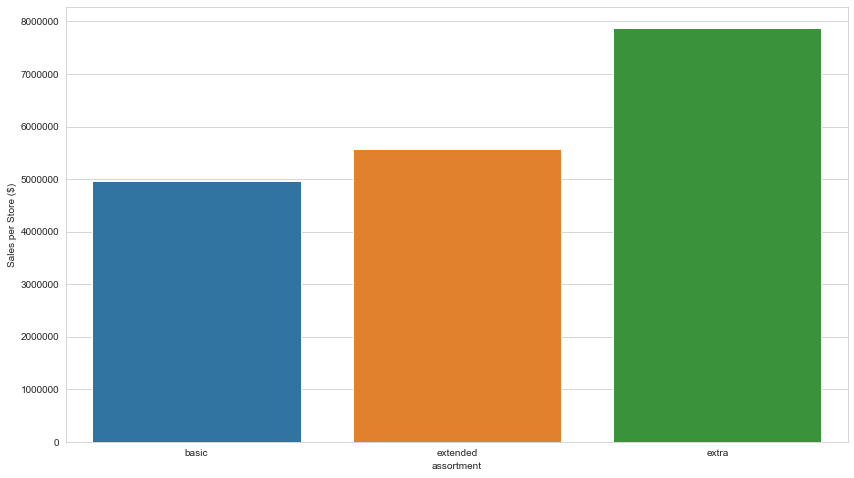

In [52]:
plt.figure(1, figsize = (14,8))
sns.barplot(x = 'assortment', y = 'total sales/store', data = aux2)
plt.ylabel("Sales per Store ($)")


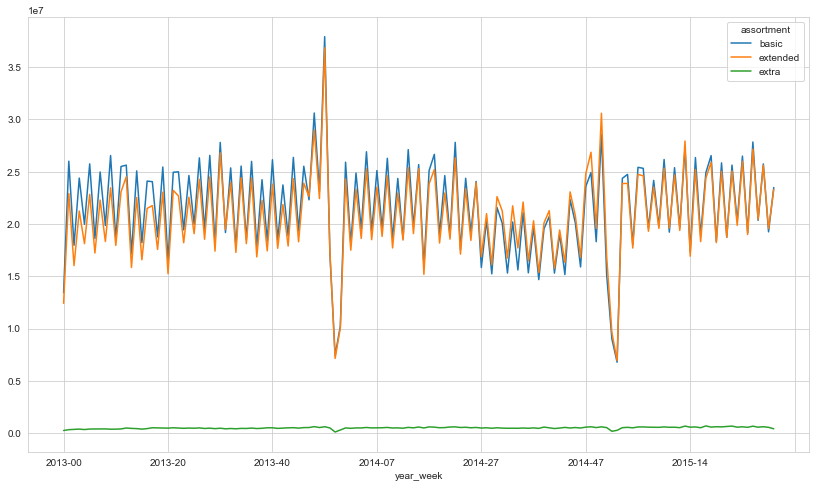

In [53]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment'])['sales'].sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(figsize=(14,8))

##### **H2**: Stores with long-term competitors should sell more.

**FALSE**: The competition time doesn't impact directly the sales.

In [54]:
aux1 = df4[['competition_time_month', 'store']].groupby('competition_time_month')['store'].nunique().reset_index()
aux1['sales'] = df4[['competition_time_month', 'sales']].groupby('competition_time_month')['sales'].sum().values
aux1['total sales/store'] = aux1['sales']/aux1['store']
aux1 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

In [55]:
aux1

,competition_time_month,store,sales,total sales/store
0,-32,3,198200,66066.666667
1,-31,11,993663,90333.000000
2,-30,16,2232685,139542.812500
3,-29,21,3175827,151229.857143
4,-28,30,4157527,138584.233333
5,-27,34,5178462,152307.705882
6,-26,36,5641349,156704.138889
7,-25,37,5978239,161574.027027
8,-24,45,6457582,143501.822222
9,-23,49,7525436,153580.326531


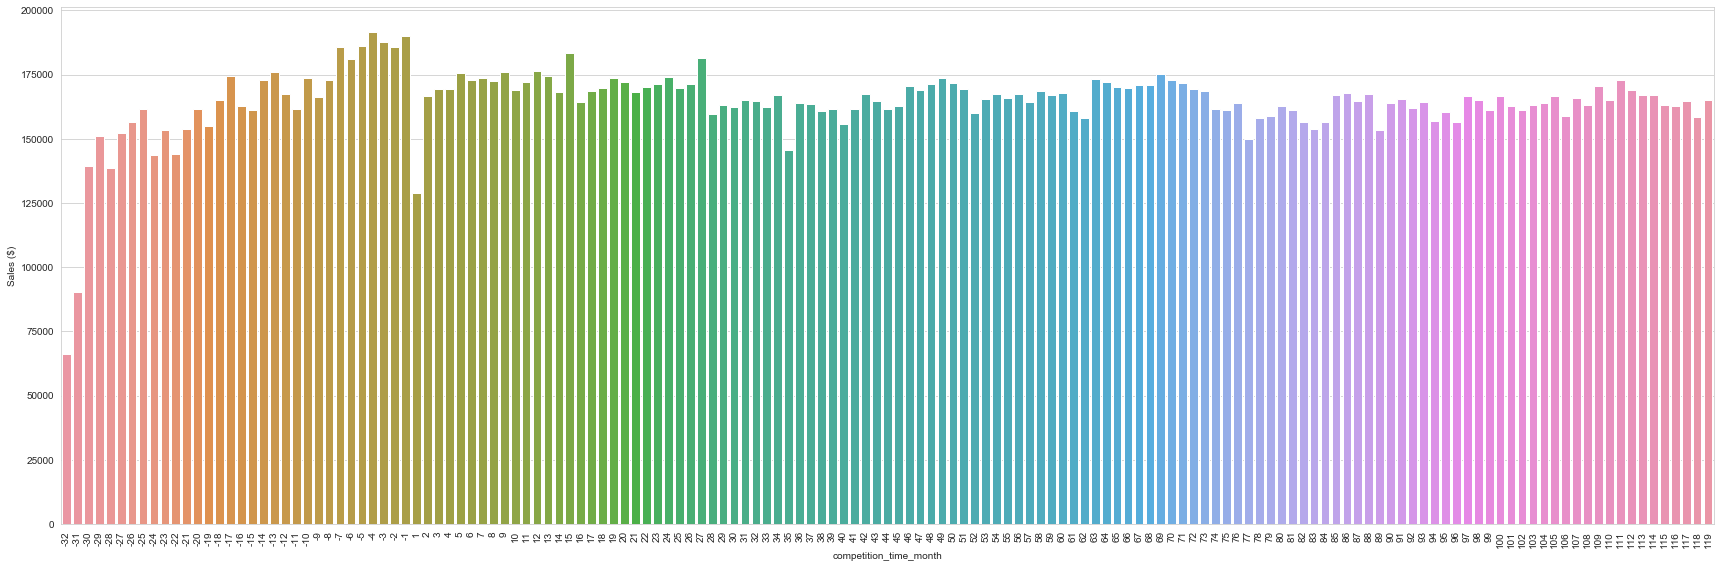

In [56]:
plt.figure(1, figsize = (24,8))
sns.barplot(x = 'competition_time_month', y = 'total sales/store', data = aux1)
plt.ylabel("Sales ($)")
plt.xticks(rotation = 90)
plt.tight_layout()

Negative time means that I know the competitor will open a store in -X months.

##### **H3**: Stores with competitors closer should sell less.
**FALSE:** The distance doesn't mean to be a competitive factor, since they have almost the same values.

In [57]:
aux1 = df4.copy()


In [58]:
bins = np.arange(0, 20000, 1000)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux1.dropna(inplace = True)

In [59]:
aux2 = aux1[['store', 'competition_distance_binned', 'sales']].groupby('competition_distance_binned')['store'].nunique().reset_index()

In [60]:
aux2 = aux1[['store', 'competition_distance_binned', 'sales']].groupby('competition_distance_binned')['store'].nunique().reset_index()
aux2['sales'] = aux1[['store', 'competition_distance_binned', 'sales']].groupby('competition_distance_binned')['sales'].sum().values
aux2['total sales/store'] = aux2['sales']/aux2['store']

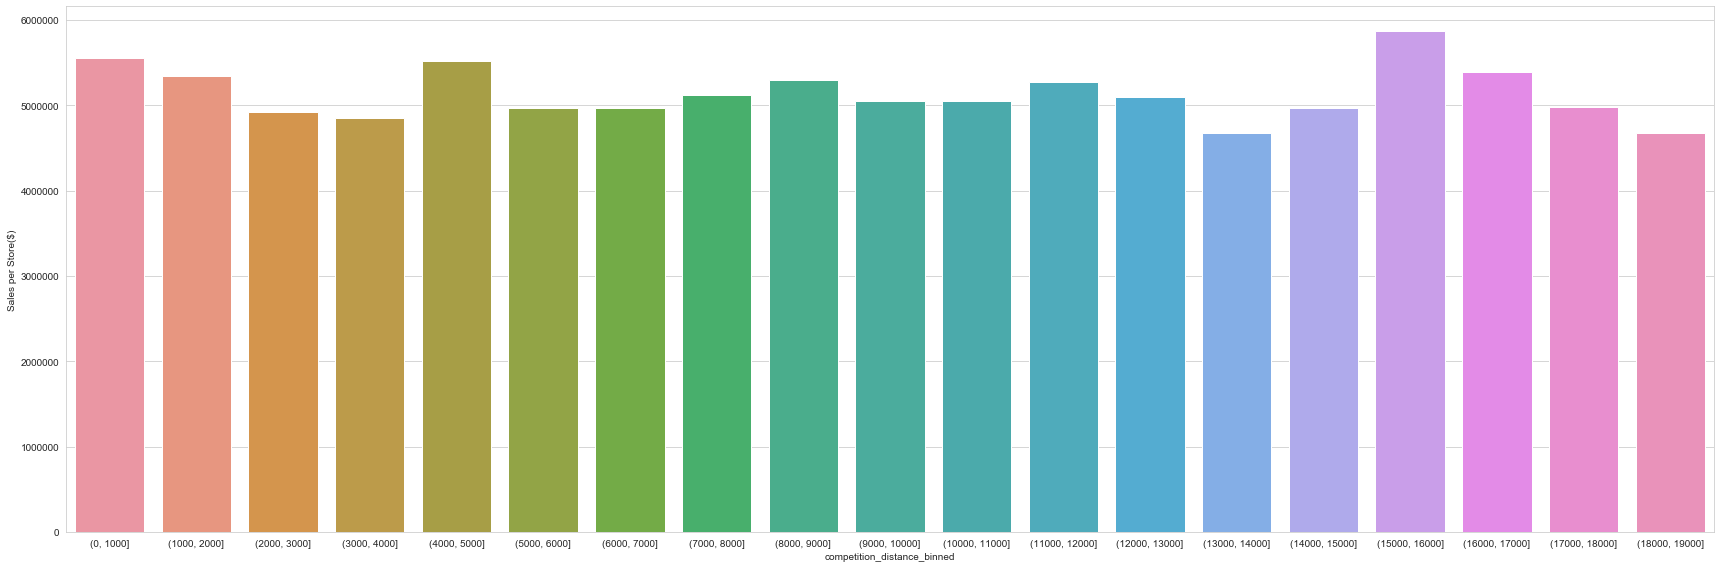

In [61]:
plt.figure(1, figsize = (24,8))
sns.barplot(x = 'competition_distance_binned', y = 'total sales/store', data = aux2)
plt.ylabel("Sales per Store($)")
plt.tight_layout()

##### **H4**: Stores with active promotion longer should sell more.
**FALSE:** Promotion time doesn't impact the sales.

In [62]:
aux1 = df4[['promo_time_week', 'store']].groupby('promo_time_week')['store'].nunique().reset_index()
aux1['sales'] = df4[['promo_time_week', 'sales']].groupby('promo_time_week')['sales'].sum().values
aux1['total sales/store'] = aux1['sales']/aux1['store']

In [63]:
regular_promo = aux1[aux1['promo_time_week'] < 0]
extended_promo = aux1[aux1['promo_time_week'] > 0]

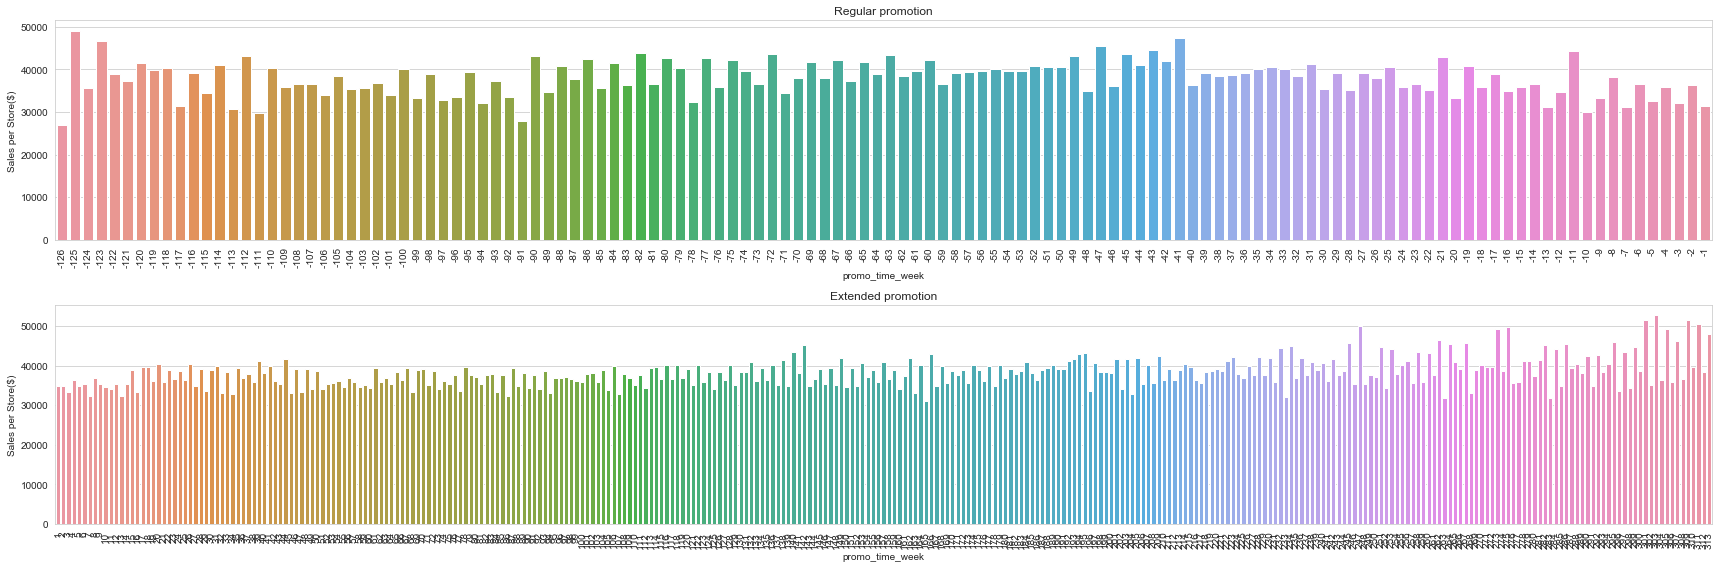

In [64]:
plt.figure(1, figsize = (24,8))

plt.subplot(2,1,1)
plt.title('Regular promotion')
sns.barplot(x = 'promo_time_week', y = 'total sales/store', data = regular_promo)
plt.ylabel("Sales per Store($)")
plt.xticks(rotation = 90)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('Extended promotion')
sns.barplot(x = 'promo_time_week', y = 'total sales/store', data = extended_promo)
plt.ylabel("Sales per Store($)")
plt.xticks(rotation = 90)
plt.tight_layout()

Promo time week negative means the sales in the regular promo and positive means sales in extended promo.

##### **H5**: Stores with more consecutive promotions should sell more.
**FALSE:** Stores that participates of regular promotion sell more than stores that participates in consecutive promotions.

In [65]:
aux1 = df4[['promo', 'promo2', 'sales', 'store']].groupby(['promo', 'promo2'])['store'].nunique().reset_index()
aux1['sales'] = df4[['promo', 'promo2', 'sales', 'store']].groupby(['promo', 'promo2'])['sales'].sum().values
aux1['total sales/store'] = aux1['sales']/aux1['store']

##### **H6**: Stores that open during the Christimas holiday should sell more.
**FALSE:** Stores that open in easter holidays sell more than Christimas and public holiday.

In [66]:
aux1 = df4[['store', 'sales', 'state_holiday']].groupby('state_holiday')['store'].nunique().reset_index()
aux1['sales'] =  df4[['store', 'sales', 'state_holiday']].groupby('state_holiday')['sales'].sum().values
aux1['total sales/store'] = aux1['sales']/aux1['store']
aux1 = aux1[aux1['state_holiday'] != 'regular_day']

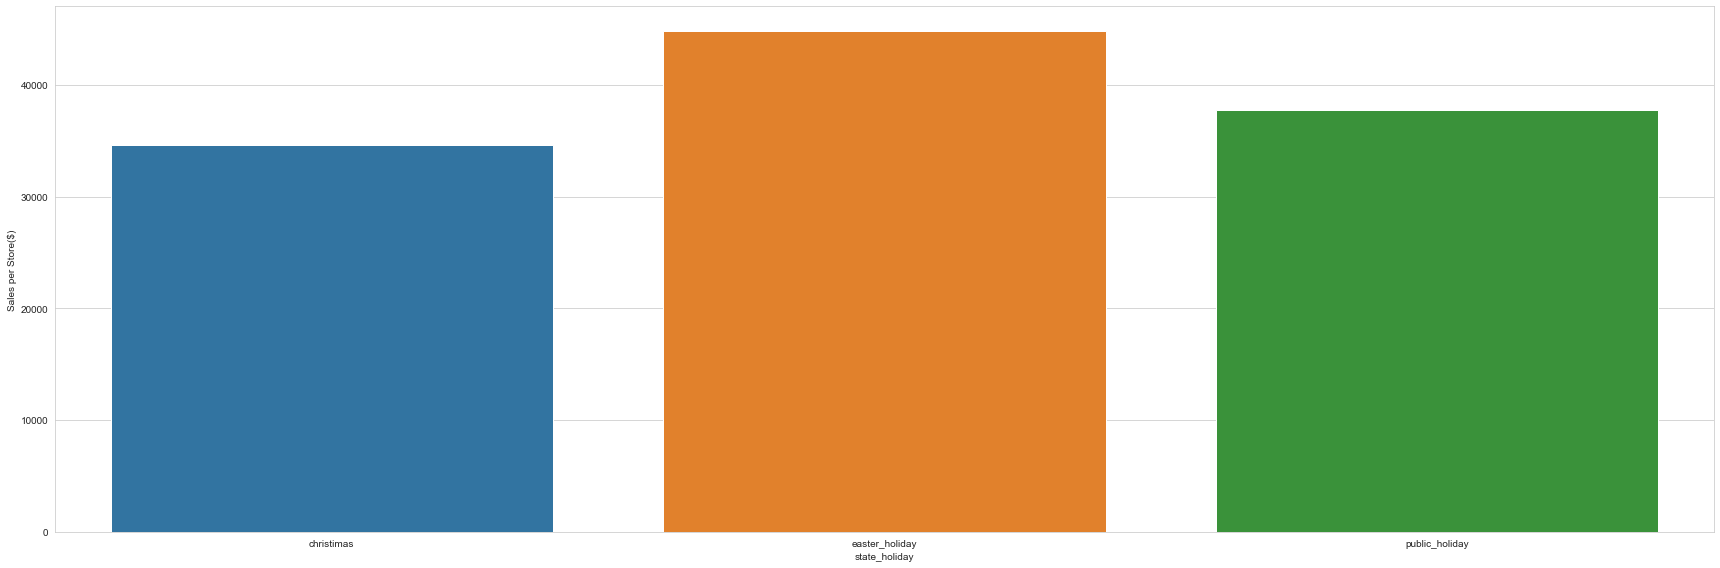

In [67]:
plt.figure(1, figsize = (24,8))
sns.barplot(x = 'state_holiday', y = 'total sales/store', data = aux1)
plt.ylabel("Sales per Store($)")
plt.tight_layout()

##### **H7**: Stores should sell more over the years.
**FALSE**: The sales are decreasing over the years.

In [68]:
aux1 = df4[df4['year'] != 2015][['year', 'sales', 'store']].groupby('year')['sales'].sum().reset_index()

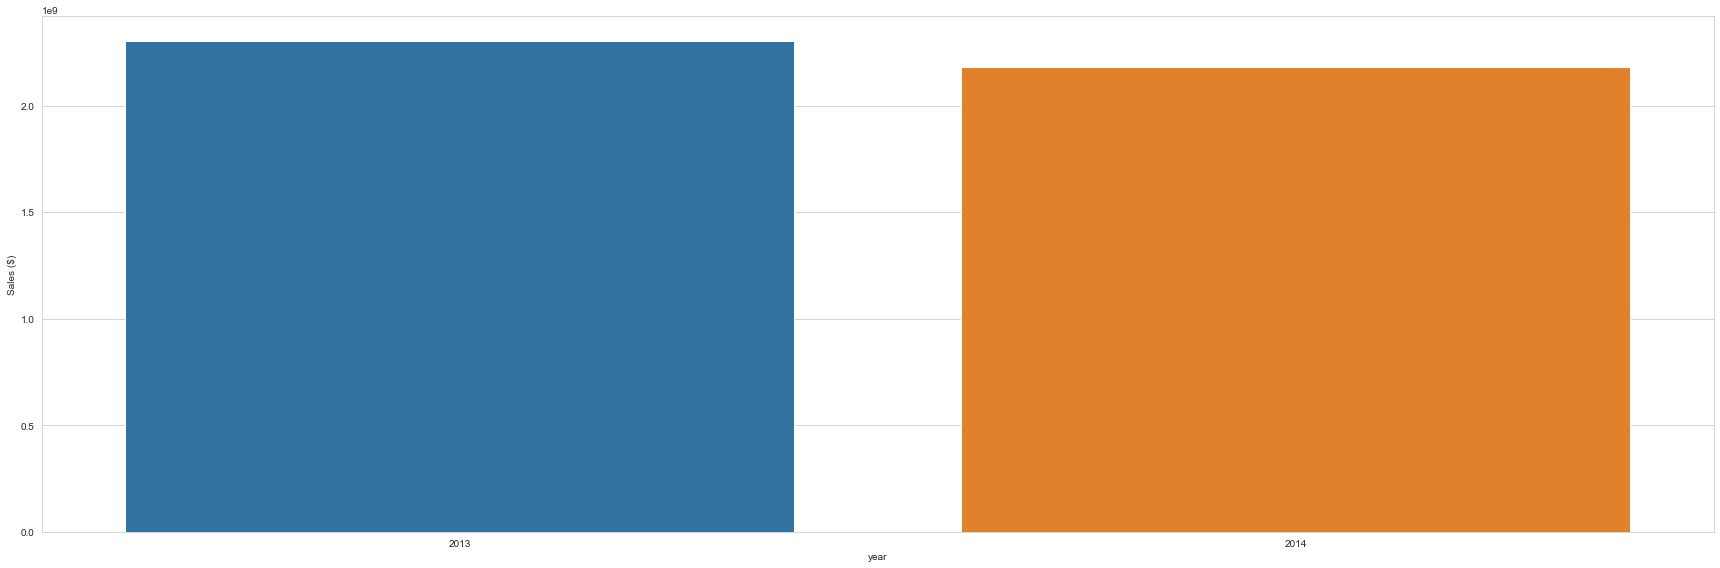

In [69]:
plt.figure(1, figsize = (24,8))
sns.barplot(x = 'year', y = 'sales', data = aux1)
plt.ylabel("Sales ($)")
plt.tight_layout()

It is important to note that 2015 is not complete, so I will not consider this year.

##### **H8**: Stores should sell more in the 2nd semester of the year.
**FALSE:** The stores are regular over the months of the year.

In [70]:
df4['date'].max()

Timestamp('2015-07-31 00:00:00')

In [71]:
aux1 = df4[df4['year'] != 2015][['month', 'sales', 'store']].groupby('month')['sales'].sum().reset_index()

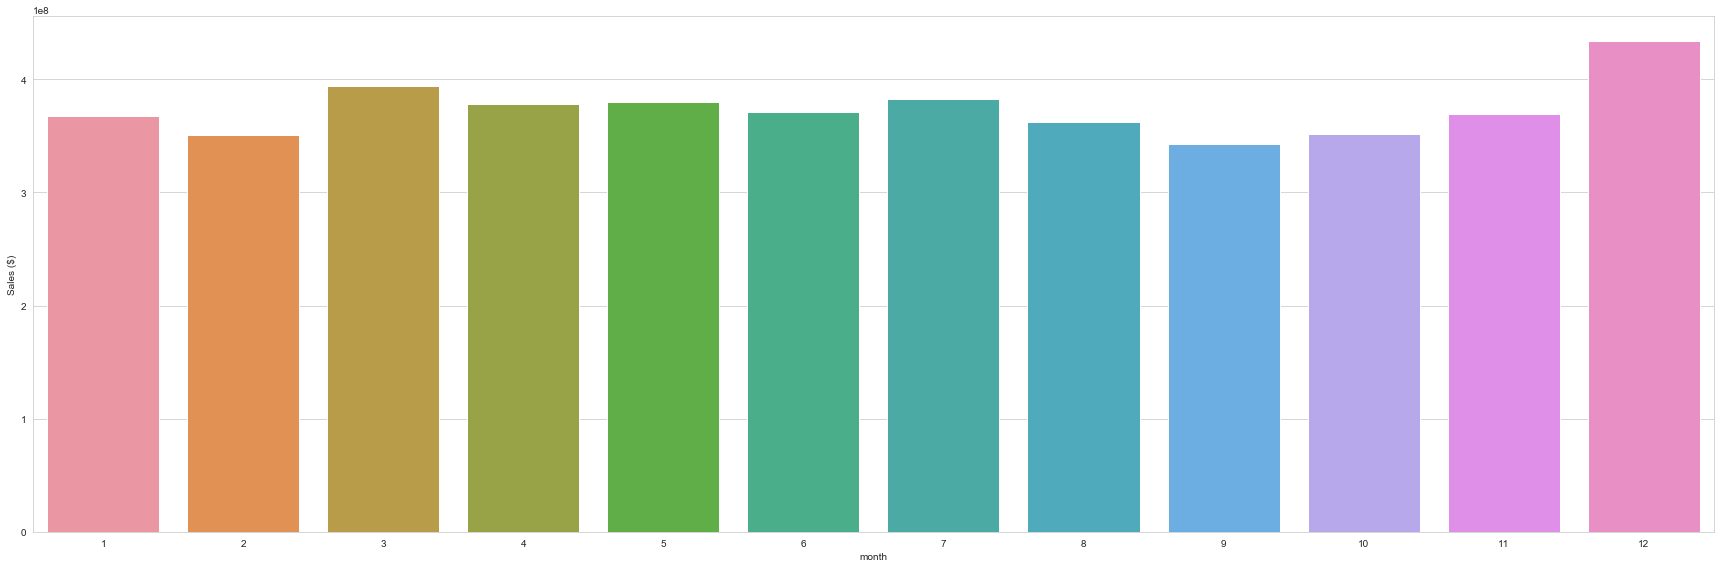

In [72]:
plt.figure(1, figsize = (24,8))
sns.barplot(x = 'month', y = 'sales', data = aux1)
plt.ylabel("Sales ($)")
plt.tight_layout()

It is important to note that 2015 is not complete, so I will not consider this year.

##### H9: Stores should sell more after the 10th day of the month.
**FALSE:** Stores sell more in the first 10 days of the month.

In [73]:
aux1 = df4[df4['year'] != 2015][['day', 'sales', 'store']].groupby('day')['sales'].sum().reset_index()

In [74]:
bins = np.arange(0, 31, 10)
aux1['day_binned'] = pd.cut(aux1['day'], bins = bins)
aux1.dropna(inplace = True)

In [75]:
aux2 = aux1.groupby('day_binned')['sales'].sum().reset_index()

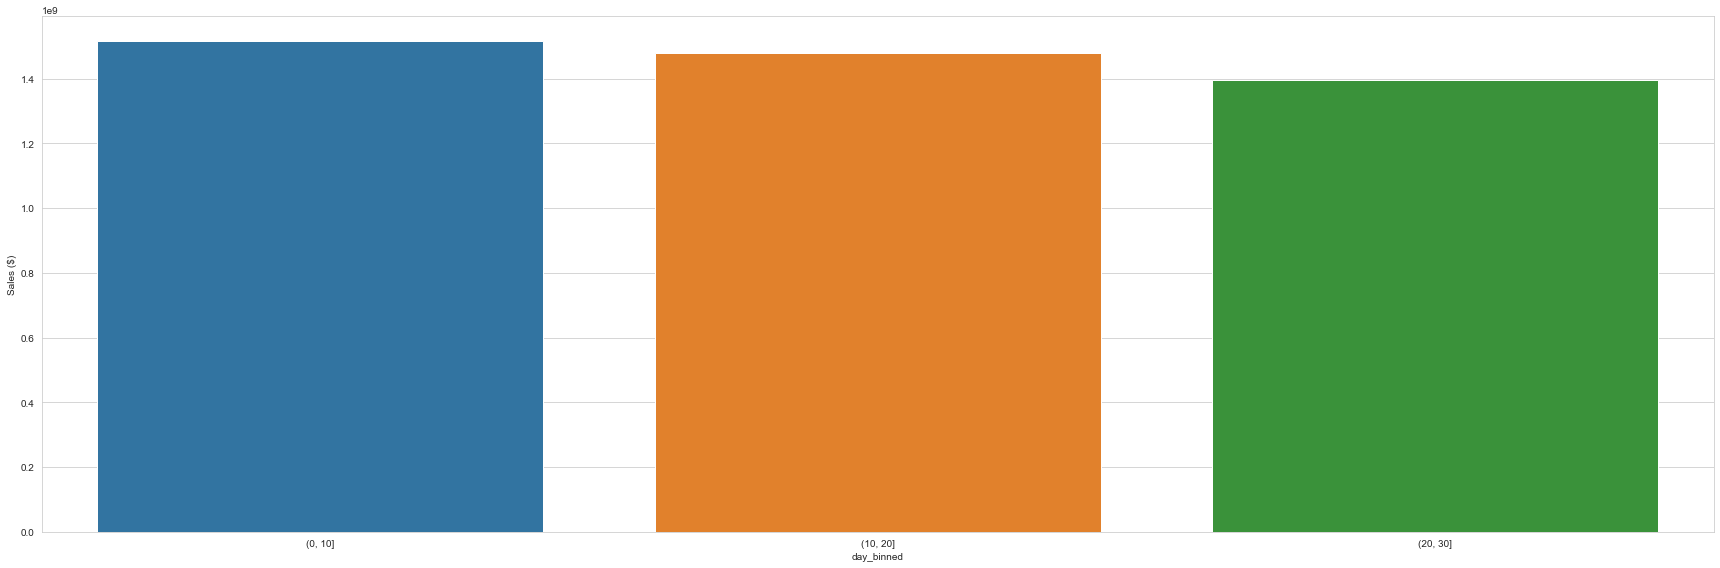

In [76]:
plt.figure(1, figsize = (24,8))
sns.barplot(x = 'day_binned', y = 'sales', data = aux2)
plt.ylabel("Sales ($)")
plt.tight_layout()

##### **H10**: Stores should sell less during the school holidays.
**TRUE**: During the school holidays, the sales are lower.

In [77]:
aux1 = df4[['school_holiday', 'store', 'sales']].groupby('school_holiday')['sales'].sum().reset_index()

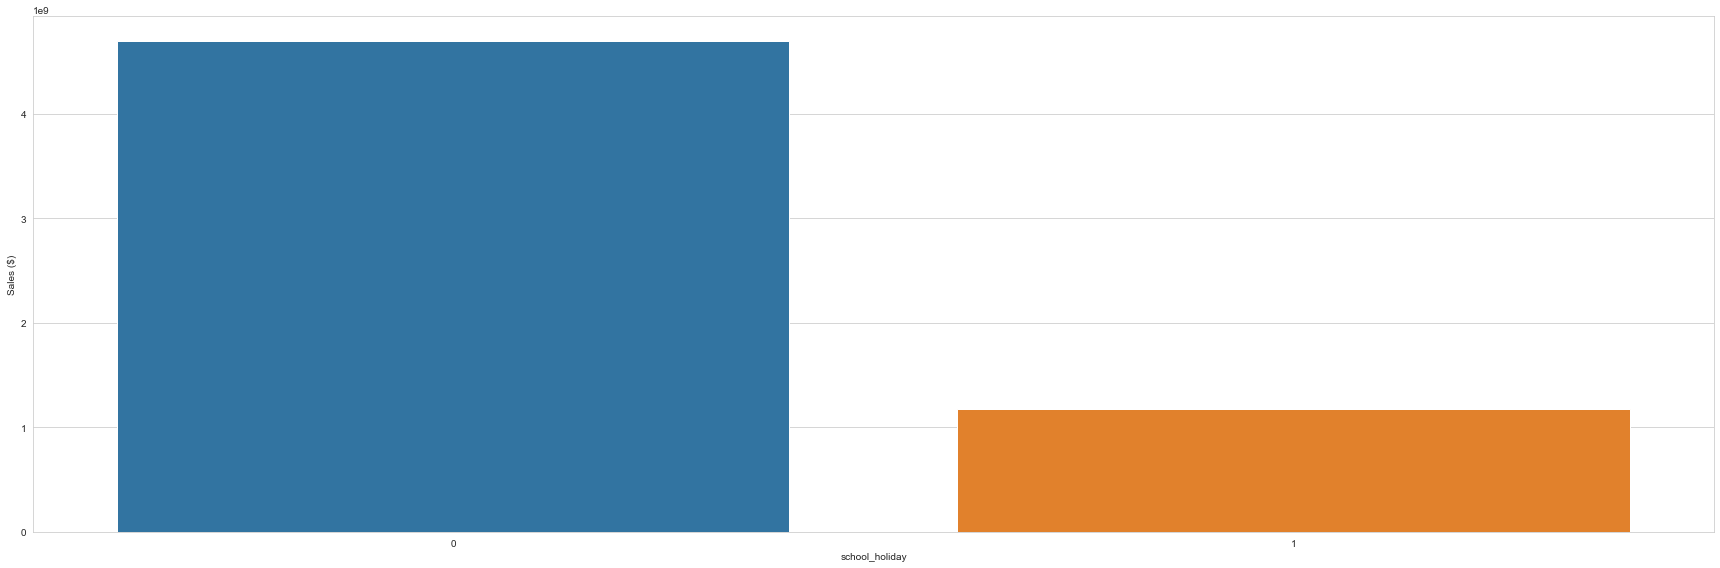

In [78]:
plt.figure(1, figsize = (24,8))
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)
plt.ylabel("Sales ($)")
plt.tight_layout()

##### **H11**: Stores should sell less during the weekend.
**TRUE**: Stores sell less during the weekend.

In [79]:
aux1 = df4[['day_of_week', 'store', 'sales']].groupby('day_of_week')['store'].nunique().reset_index()
aux1['sales'] = df4[['day_of_week', 'store', 'sales']].groupby('day_of_week')['sales'].sum().values
aux1['total sales/store'] = aux1['sales']/aux1['store']

In [80]:
aux1['is_weekend'] = aux1.apply(lambda x: 1 if (x['day_of_week'] == 6) | (x['day_of_week'] == 7) else 0, axis = 1)

In [81]:
aux2 = aux1.groupby('is_weekend')['total sales/store'].sum().reset_index()

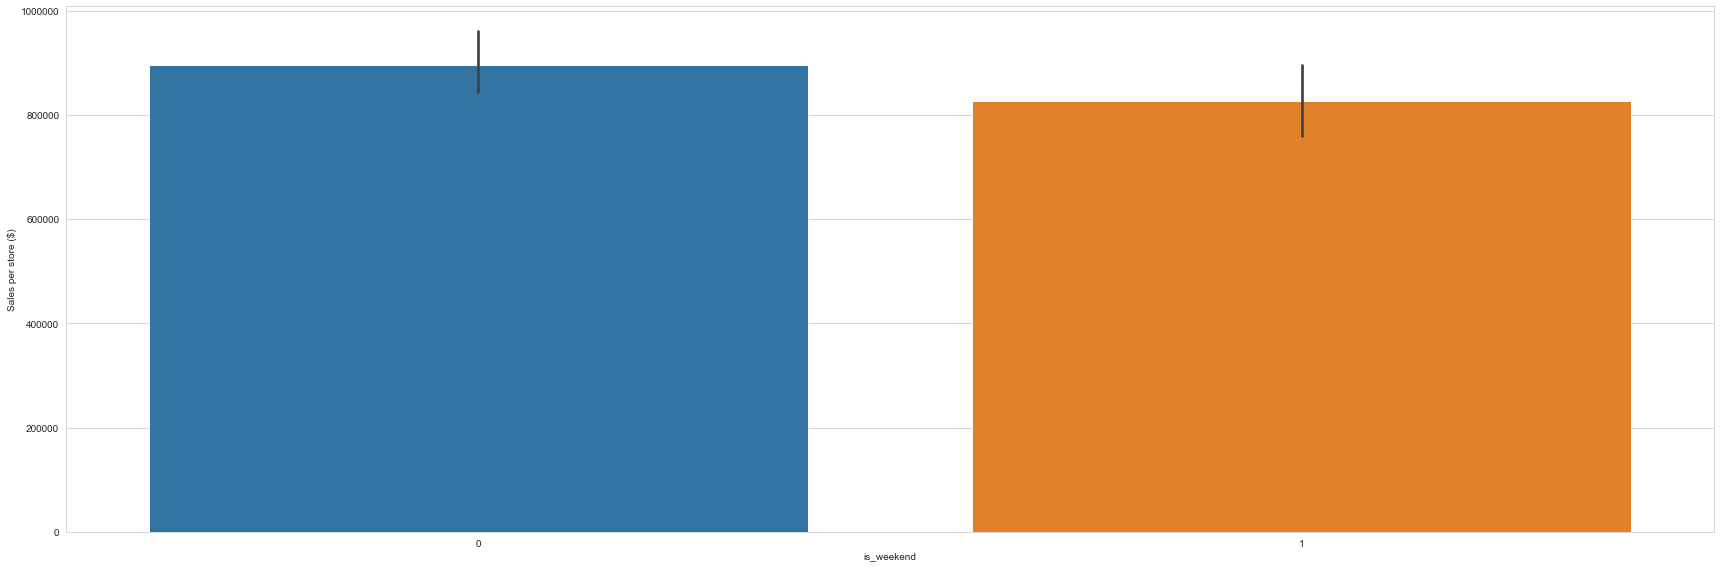

In [82]:
plt.figure(1, figsize = (24,8))
sns.barplot(x = 'is_weekend', y = 'total sales/store', data = aux1)
plt.ylabel("Sales per store ($)")
plt.tight_layout()

### 4.3 Multivariate Analysis

#### Numerical Variables

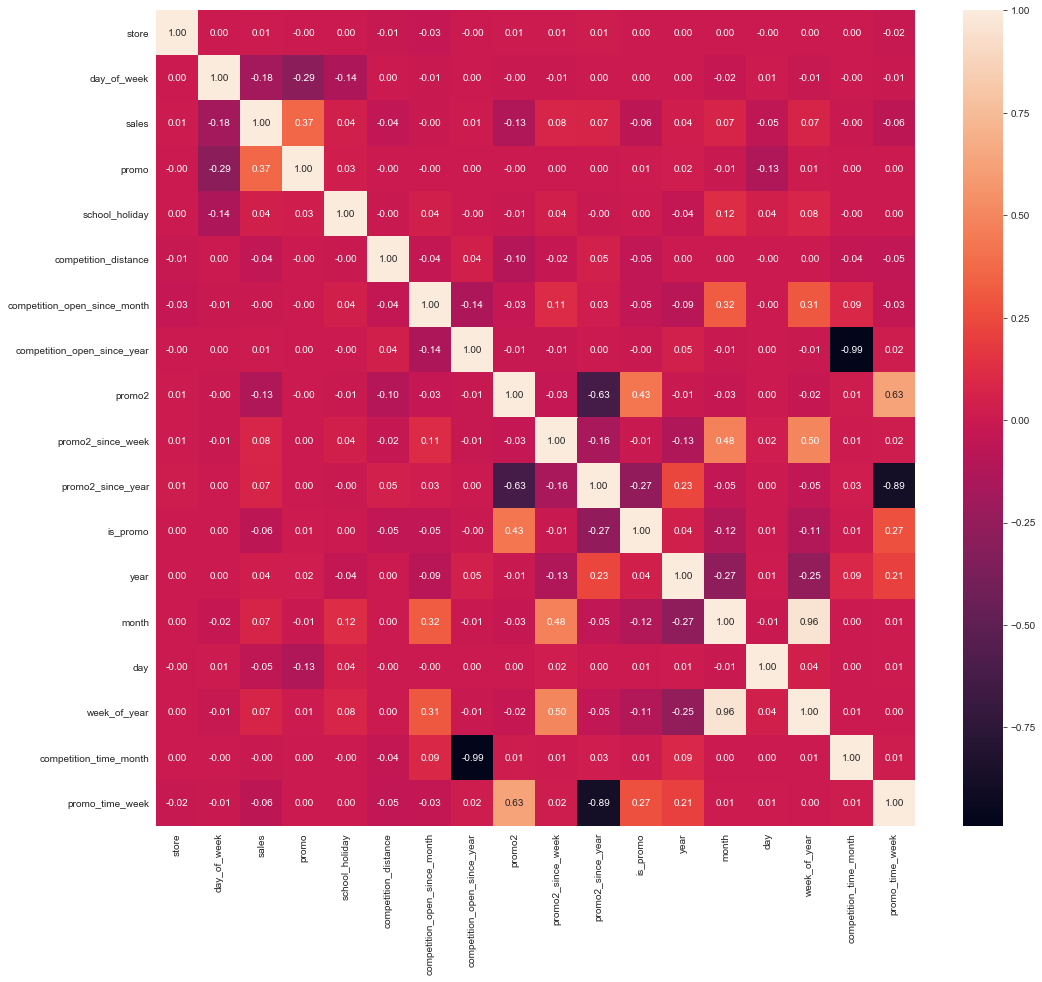

In [83]:
# creating a figure and adjusting its size
plt.figure(figsize= (17, 15))

# creating a correlation matrix from 'df3_num' dataframe
corr_matrix = num_attributes.corr(method = 'pearson')

# creating a heatmap graph using the correlation matrix 'corre_num' as data
sns.heatmap(corr_matrix, annot = True, fmt= '.2f')


**Observations**:
- For numerical attributes, I am going to use the correlation coefficient;
- promo2_since_year and promo2 is a strong negative correlation (-0.63);
- is_promo and promo2 has a medium correlation (0.43);
- month and promo2_since_week has a medium correlation (0.50);
- competition_time_month and competition_open_since_year has a strong negative correlation (-0.99);
- promo_time_week and promo2 has a strong correlation (0.63);
- promo_time_week and promo2_since_year has a strong negative correlation (-0.89);

#### Categorical Variables

In [84]:
cat_att_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range(len(cat_att_list)):
    corr_list = []
    for j in range(len(cat_att_list)):
        ref = cat_att_list[i]
        feat = cat_att_list[j]
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        corr_list.append(corr)
    corr_dict[ref] = corr_list

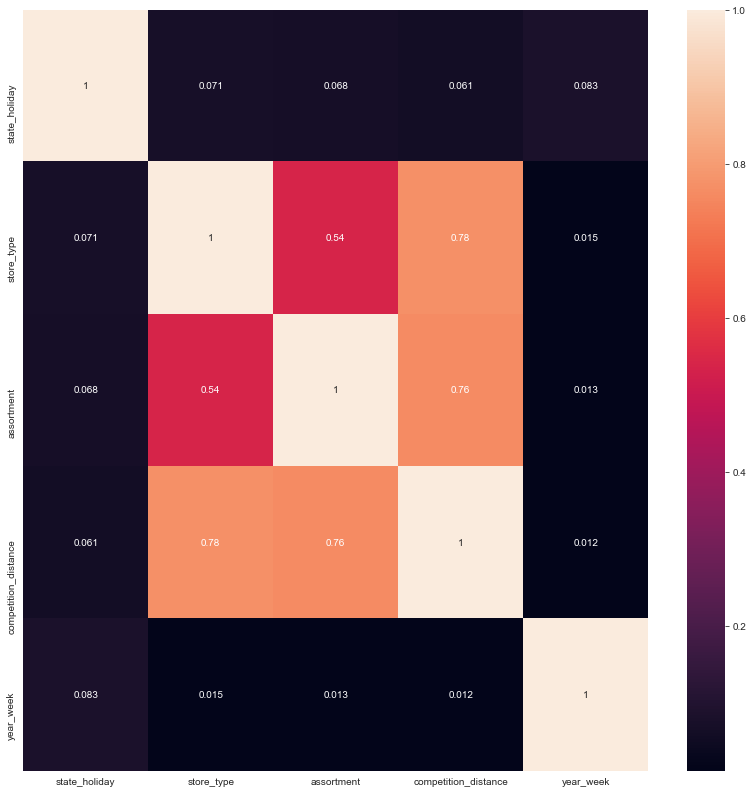

In [85]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)

plt.figure(1, figsize=(14, 14))
sns.heatmap(d, annot=True)

**Observations**:
- assortment and store type has medium correlation (0.54)
- competition distance and store type has strong correlation (0.78)
- competition distance and assortment has a strong correlation (0.78)

## 5.0 Data Preparation

Since most Machine Learning models make some assumptions for perform well, we need to treat the variables in order to try to help the model:
    
- Variables needs to be at the same scale;
- Variables needs to follow a normal distribution; 
- Categorical variables need to be transformed to numerical.

In [170]:
df5 = df4.copy()

### 5.1 Split in train and test

First of all, I will split between train and test:

In [171]:
X_train = df5[df5['date'] < (df5['date'].max() - datetime.timedelta(weeks=6))]
y_train = df5[df5['date'] < (df5['date'].max() - datetime.timedelta(weeks=6))]['sales']

X_test = df5[df5['date'] >= (df5['date'].max() - datetime.timedelta(weeks=6))]
y_test = df5[df5['date'] >= (df5['date'].max() - datetime.timedelta(weeks=6))]['sales']

In [172]:
X_train.drop('sales', axis = 1, inplace = True)
X_test.drop('sales', axis = 1, inplace = True)

C:\Users\joaop\anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [173]:
print("Size of train set:", X_train.shape)
print("Size of test set:", X_test.shape)

Size of train set: (802942, 24)
Size of test set: (41396, 24)


### 5.2 Rescaling

In this subsection we are going to use the previous knowledge about data and apply techniques of transformation and rescaling of variables.

I wil use MinMaxScaler and Robust Scaler due to the outliers found.

**RobustScaler**: Robust in the presence of outliers, will be applied at variables that have a significant amount of outliers

**MinMaxScaler**: Sensitive in the presence of outliers, will be applied at variables that don't have a significant amount of outliers

In [174]:
# Initialize the method
mm = MinMaxScaler()

In [175]:
# Initialize the method
rs = RobustScaler()

In [176]:
# Min max Scaling
X_train['promo2_since_week'] = mm.fit_transform(X_train[['promo2_since_week']])
X_test['promo2_since_week'] = mm.transform(X_test[['promo2_since_week']])

X_train['promo2_since_year'] = mm.fit_transform(X_train[['promo2_since_year']])
X_test['promo2_since_year'] = mm.transform(X_test[['promo2_since_year']])

X_train['year'] = mm.fit_transform(X_train[['promo2_since_week']])
X_test['year'] = mm.transform(X_test[['year']])

# Robust Scaling

X_train['competition_open_since_year'] = rs.fit_transform(X_train[['competition_open_since_year']])
X_test['competition_open_since_year'] = rs.transform(X_test[['competition_open_since_year']])

X_train['competition_time_month'] = rs.fit_transform(X_train[['competition_time_month']])
X_test['competition_time_month'] = rs.transform(X_test[['competition_time_month']])

X_train['promo_time_week'] = rs.fit_transform(X_train[['promo_time_week']])
X_test['promo_time_week'] = rs.transform(X_test[['promo_time_week']])

X_train['competition_distance'] = rs.fit_transform(X_train[['competition_distance']])
X_test['competition_distance'] = rs.transform(X_test[['competition_distance']])

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

### 5.3 Transformations

**Log Transform**:
Since the targer variable doesn't follow a perfect normal distribution, we need to use a log transformation to turn it on a normal distribution;

**Nature Transform**:
In nature transformation, we have to bring the true nature of the data into the dataset. One example is the variable 'month', which is cyclic and has to be transformed, as the months are repeated every year that starts. But for this we don't just enumerate the months from 1 to 12 because we lose the sense of cycle due to the different distances.

For example, we take the month January 2018, we find that there is long distance until December 2018, but not necessarily, December 2018 is far from the month of January 2019. What happens is that December 2018 has the same distance as January from 2019 what March 2018 has from April 2018. And the same distance keeps a cycle.

In [177]:
# Log transform
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)


# Nature 
# transforming the 'day' column values into sine and cosine values and creating the new features
X_train['day_sin'] = X_train['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
X_train['day_cos'] = X_train['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))
X_test['day_sin'] = X_test['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
X_test['day_cos'] = X_test['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))

# transforming the 'day_of_week' column values into sine and cosine values and creating the new features
X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))
X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))


# transforming the 'month' column values into sine and cosine values and creating the new features
X_train['month_sin'] = X_train['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
X_train['month_cos'] = X_train['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))
X_test['month_sin'] = X_test['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
X_test['month_cos'] = X_test['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))

# transforming the 'week_of_year' column values into sine and cosine values and creating the new features
X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))
X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [178]:
X_train.drop(['day_of_week', 'day', 'month', 'week_of_year', 'year_week', 'competition_since', 'promo_since'], axis = 1, inplace = True)
X_test.drop(['day_of_week', 'day', 'month', 'week_of_year', 'year_week', 'competition_since', 'promo_since'], axis =1, inplace = True)

C:\Users\joaop\anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### 5.4 Categorical Encoding

In the Encoding technique, we convert the categorical variable into a numeric variable keeping the information content. 

**Label Encoding**: Transform each label in a number, not considering any hierarchical condition.

**One-Hot Encoding**: Transform each label in an array where the length of array is the number of possible value that it can assume. 

**Ordinal Encoding**: Transform each label in a number based on hierarchical condition.


In [179]:
# Label Encoder
le = LabelEncoder()

In [180]:
# Initialize label encoder
le = LabelEncoder()

In [181]:
X_train['store_type'] = le.fit_transform(X_train[['store_type']])
X_test['store_type'] = le.transform(X_test[['store_type']])

X_train['assortment'] = le.fit_transform(X_train[['assortment']])
X_test['assortment'] = le.transform(X_test[['assortment']])

X_train['state_holiday'] = le.fit_transform(X_train[['state_holiday']])
X_test['state_holiday'] = le.transform(X_test[['state_holiday']])

C:\Users\joaop\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

### 5.5 Feature Selection w/ Boruta

Since some variables are not important for the model and it can generalize better in new data, I will be using a Boruta algorithm for feature selection.

This algorithm is based on Wrapper Method, where it picks randomly 2 variables, creates a shadow and mix the examples. Then, the variables are used to train a Random Forest model (in this case) and the performance is checked. If the performance increases, the variable remains. This is done several times until the algorithm find a subset of variables.

In [121]:
# defining model that will be checked by the boruta method
rfr_model = RandomForestRegressor(n_jobs = -1, random_state= 42)

# defining the train arrays
x_train_boruta = X_train.drop(columns= ['date']).values
y_train_boruta = y_train.values.ravel()

# instantiating the boruta method
boruta = BorutaPy(rfr_model, n_estimators= 'auto', verbose= 2, random_state= 301)

# training the boruta method
boruta.fit(x_train_boruta, y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	5


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	5


BorutaPy(estimator=RandomForestRegressor(n_estimators=69, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x2B520C98EB8),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2B520C98EB8, verbose=2)

In [122]:
# instantiating the dataset selected columns by the boruta method
cols = boruta.support_.tolist()
boruta_selected_features = X_train.drop(columns= ['date']).iloc[:, cols].columns.to_list()

# displaying the selected features by boruta
print('Boruta selected features:')
boruta_selected_features

Boruta selected features:


['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'week_of_year_cos']

In [145]:
boruta_selected_features = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'year', 'competition_time_month', 'promo_time_week', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'week_of_year_cos']

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'week_of_year_cos']

# 6.0 Machine Learning Models

The machine learning models section will test 4 different models:

- Baseline model
- Linear Regression 
- Random Forest Regressor
- XGBoost 

In [182]:
X_train = X_train[['date'] + boruta_selected_features]
X_test = X_test[['date'] + boruta_selected_features]

In [190]:
X_train['sales'] = y_train

### 6.1 Baseline - Average Model

To compare my solution with a baseline, I will be choosing a Average Model. I will use the average sale for each store and consider it as the predictions.

In [183]:
baseline = X_test.copy()

In [184]:
baseline['sales'] = y_test.values

In [185]:
df_baseline = baseline[['store', 'sales']].groupby('store')['sales'].mean().reset_index().rename(columns = {'sales':'predictions'})

baseline = pd.merge(baseline, df_baseline, how = 'left', on = 'store')

yhat_baseline = baseline['predictions']

baseline_error = ml_error('Baseline - Average', np.expm1(y_test),  np.expm1(yhat_baseline))
baseline_error

,Model Name,MAE,MAPE,RMSE
0,Baseline - Average,1354.800353,0.455051,1835.135542


### 6.2 Linear Regression

In [186]:
lr = LinearRegression()
lr.fit(X_train.drop(['date'], axis = 1), y_train.values)

lr_pred = lr.predict(X_test.drop(['date'], axis = 1))

lr_error = ml_error("Linear Regression", np.expm1(y_test),  np.expm1(lr_pred))
lr_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,3.927638e+127,6.397297e+123,4.006128e+127


#### 6.2.1 Linear Regression - CV

In [196]:
lr_result_cv = cross_validation(X_train, 5, 'Linear Regression', lr, verbose = True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2075.46 +/- 303.31,0.3 +/- 0.01,2954.3 +/- 474.07


### 6.3 Random Forest Regressor

In [127]:
rf = RandomForestRegressor(n_estimators=100,  max_depth = 10)
rf.fit(X_train.drop(['date'], axis = 1), y_train.values)

rf_pred = rf.predict(X_test.drop(['date'], axis = 1))

rf_error = ml_error("Random Forest", np.expm1(y_test),  np.expm1(rf_pred))
rf_error

,Model Name,MAE,MAPE,RMSE
0,Random Forest,1639.972154,0.252338,2309.75717


In [197]:
rf_result_cv = cross_validation(X_train, 5, 'Random Forest', rf, verbose = True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,Random Forest,1752.65 +/- 247.07,0.24 +/- 0.01,2477.68 +/- 349.11


### 6.4 XGBoost

In [200]:
xgb = xgboost.XGBRegressor(n_estimators=100)
xgb.fit(X_train.drop(['date', 'sales'], axis = 1), y_train.values)


xgb_pred = xgb.predict(X_test.drop(['date'], axis = 1))

# Performance
xgb_error = ml_error('XGBoost', np.expm1(y_test), np.expm1(xgb_pred))
xgb_error

,Model Name,MAE,MAPE,RMSE
0,XGBoost,893.686249,0.134838,1279.184043


In [201]:
xgb_result_cv = cross_validation(X_train, 5, 'XGBoost', xgb, verbose = True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1084.54 +/- 182.26,0.15 +/- 0.02,1556.67 +/- 255.77


## 7.0 Models Comparison

In [206]:
models = [lr_result_cv, rf_result_cv, xgb_result_cv]
pd.concat(models)

,Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2075.46 +/- 303.31,0.3 +/- 0.01,2954.3 +/- 474.07
0,Random Forest,1752.65 +/- 247.07,0.24 +/- 0.01,2477.68 +/- 349.11
0,XGBoost,1084.54 +/- 182.26,0.15 +/- 0.02,1556.67 +/- 255.77


In [207]:
baseline_error

,Model Name,MAE,MAPE,RMSE
0,Baseline - Average,1354.800353,0.455051,1835.135542


By comparing the tested models and the baseline, I can consider the best model the XGBoost, since the RMSE metric is widely used for comparison of errors. Linear Regression and Random Forest are worse than the dummy model.

## 8.0 Hyper-parameters tuning

This section is used to choose a grid of parameters that can be varied in a XGBoost model and it is evaluated on a cross-validation. The best set of parameters is used as final model.

In [210]:
# Range of parameters for grid search
params = {"n_estimators": list(np.arange(100, 2000, 100)),
     "max_depth": list(np.arange(3, 12, 3)),
     "eta": list(np.arange(0.1, 1, 0.1)),
     "subsample": list(np.arange(0.3, 1, 0.1)),
     "colsample_bytree": list(np.arange(0.1, 1, 0.1))}

In [215]:
# Setting the number of possible combinations in the grid search
evaluations= 15

# Final metrics dataframe
final_metrics = pd.DataFrame()

# Iterate over evelatuations
for i in range(evaluations):
    print("Evaluation {} / {}".format(i, evaluations))
    # Choose random parameter combinations 
    hp = {k: random.sample(v, 1)[0] for k, v in params.items()}
       
    # XGBoost model to be tunned
    xgb_not_tunned = xgboost.XGBRegressor(objective='reg:squarederror',
                          n_estimators= hp['n_estimators'], 
                          eta= hp['eta'], 
                          max_depth= hp['max_depth'], 
                          subsample= hp['subsample'],
                          colsample_bytree= hp['colsample_bytree'],
                          random_state= 301)
       
    # Result in a 5 fold cross-validation
    xgb_cross_performance = cross_validation(X_train, 5, 'XGBoost', xgb_not_tunned, verbose = True)
    
    # Add to datarame the hyperparameters
    xgb_cross_performance['Hyperparameters'] = str(hp)
    
    # Append to the metrics dataframe
    final_metrics = final_metrics.append(xgb_cross_performance)

final_metrics.reset_index(drop= True, inplace= True)

# returning the dataset
final_metrics


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number:

,Model,MAE CV,MAPE CV,RMSE CV,Hyperparameters
0,XGBoost,1022.15 +/- 142.6,0.14 +/- 0.01,1476.24 +/- 242.1,"{'n_estimators': 1500, 'max_depth': 9, 'eta': ..."
1,XGBoost,928.93 +/- 149.83,0.13 +/- 0.02,1326.43 +/- 207.97,"{'n_estimators': 300, 'max_depth': 6, 'eta': 0..."
2,XGBoost,1095.81 +/- 134.58,0.15 +/- 0.01,1552.29 +/- 178.69,"{'n_estimators': 800, 'max_depth': 3, 'eta': 0..."
3,XGBoost,1070.29 +/- 217.02,0.15 +/- 0.03,1508.15 +/- 309.28,"{'n_estimators': 1600, 'max_depth': 6, 'eta': ..."
4,XGBoost,1072.82 +/- 168.03,0.15 +/- 0.02,1499.76 +/- 241.59,"{'n_estimators': 1400, 'max_depth': 3, 'eta': ..."
5,XGBoost,1215.61 +/- 258.18,0.17 +/- 0.03,1692.71 +/- 331.89,"{'n_estimators': 500, 'max_depth': 3, 'eta': 0..."
6,XGBoost,1799.09 +/- 243.96,0.25 +/- 0.02,2559.25 +/- 306.83,"{'n_estimators': 400, 'max_depth': 6, 'eta': 0..."
7,XGBoost,1082.92 +/- 217.5,0.15 +/- 0.02,1568.95 +/- 343.5,"{'n_estimators': 300, 'max_depth': 6, 'eta': 0..."
8,XGBoost,1509.19 +/- 207.67,0.22 +/- 0.02,2134.44 +/- 272.08,"{'n_estimators': 1700, 'max_depth': 3, 'eta': ..."
9,XGBoost,1209.32 +/- 217.92,0.16 +/- 0.02,1755.7 +/- 341.15,"{'n_estimators': 1100, 'max_depth': 9, 'eta': ..."


Best Model:

In [225]:
final_model = xgboost.XGBRegressor(objective='reg:squarederror',
                          n_estimators= 1800, 
                          eta= 0.2, 
                          max_depth= 9, 
                          subsample= 0.5,
                          colsample_bytree= 0.7)

final_model.fit(X_train[boruta_selected_features], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1800, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [228]:
# Saving the best model
pickle.dump(final_model, open('../model/xgb_best_model.pkl', 'wb'))

# 9.0 Business Performance

The section of business performance will be divided in two main analysis:
- Error of ML Model
- Scenarios for the next week

### 9.1 Error Analysis of ML Model

In [334]:
df9 = X_test.copy()
df9['sales'] = y_test

In [335]:
df9['predictions'] = final_model.predict(X_test[boruta_selected_features])

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(df9['predictions'])

df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['sales'] / df9['predictions']

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


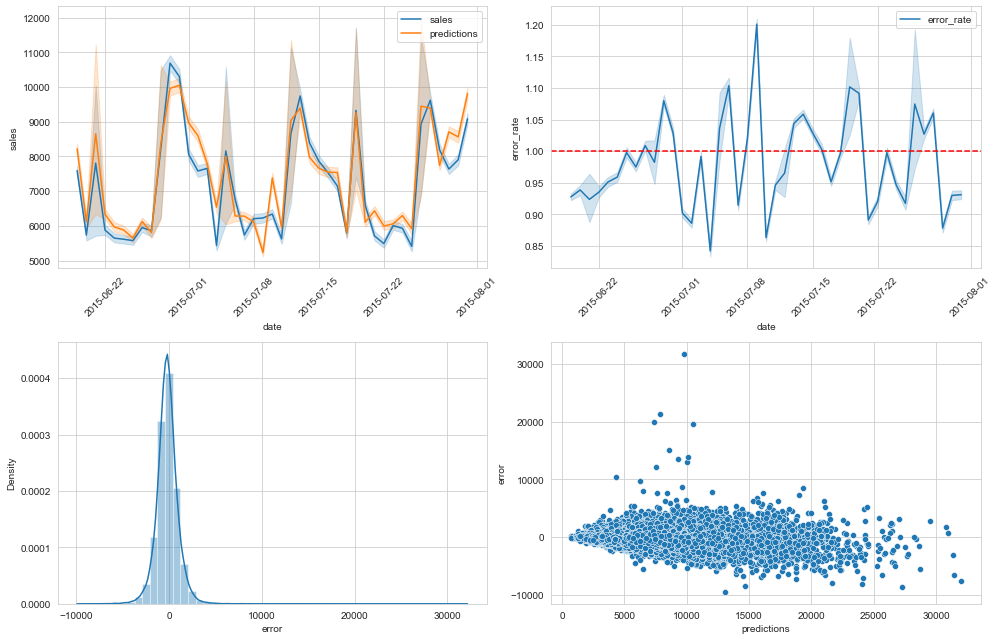

In [345]:
plt.figure(1, figsize = (14,9))

plt.subplot(2,2,1)
sns.lineplot(x = 'date', y ='sales', label = 'sales', data = df9)
sns.lineplot(x = 'date', y ='predictions', label = 'predictions', data = df9)
plt.xticks(rotation = 45)

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y ='error_rate', label = 'error_rate', data = df9)
plt.axhline(1, linestyle='--', color='r')
plt.xticks(rotation = 45)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x = 'predictions', y = 'error', data = df9)

plt.tight_layout()

**Observations**:
- By analyzing the time series, we can check the predictions and sales are almost the same but some peeks the model can represent well.
- The distribution of the error follows a normal distribution with mean 0, which indicates a good performance.
- The error rate can show when the deviations happen, it can help to observe dates and check if some phenomenom happened.
- Observing the scatter plot of predictions and error, it follows a horizontal tube that indicates a good fit, and the predictions don't have a trend. 

### 9.2 Scenarios for the next 6 weeks

In [337]:
df_comp = df9[['store', 'date', 'sales', 'predictions']].groupby('store')['sales'].sum().reset_index()
df_comp['predictions'] = df9[['store', 'date', 'sales', 'predictions']].groupby('store')['predictions'].sum().values

In [338]:
aux_mae = df9[['store', 'date', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: "MAE"})
aux_mape = df9[['store', 'date', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: "MAPE"})
aux_rmse = df9[['store', 'date', 'sales', 'predictions']].groupby('store').apply(lambda x: np.sqrt(mean_squared_error(x['sales'], x['predictions']))).reset_index().rename(columns = {0: "RMSE"})

aux_metrics = pd.merge(aux_mae, aux_mape, how = 'left', on = 'store')
aux_metrics = pd.merge(aux_metrics, aux_rmse, how = 'left', on = 'store')

In [339]:
df_comp = pd.merge(df_comp, aux_metrics, how = 'left', on = 'store')

In [340]:
df_comp.sort_values('MAPE')[:5]

,store,sales,predictions,MAE,MAPE,RMSE
555,556,262229.0,264597.31250,451.057063,0.065925,577.553952
848,849,311063.0,312438.62500,612.451225,0.072983,770.283204
115,116,261317.0,263526.40625,506.821012,0.073797,626.416376
103,104,388202.0,387067.59375,775.903716,0.073948,949.850029
973,974,451899.0,434912.46875,948.654112,0.075020,1287.148196


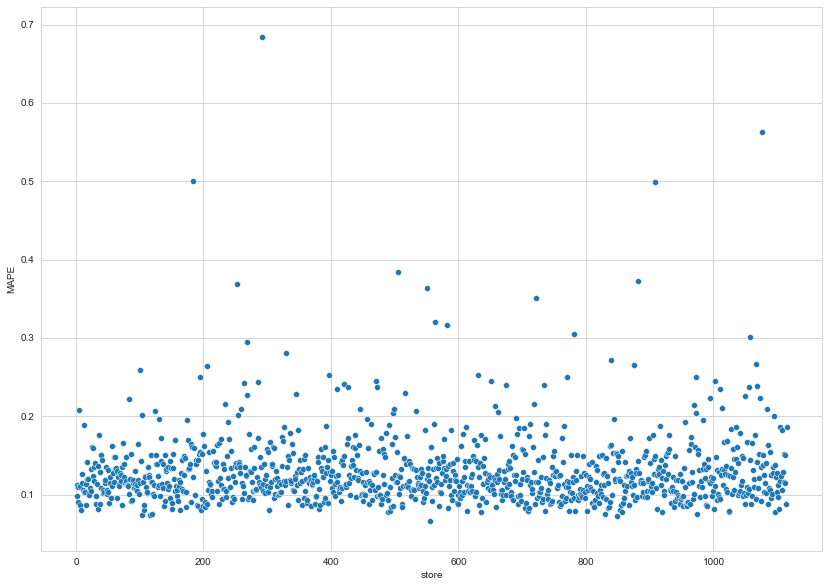

In [341]:
plt.figure(1, figsize = (14,10))
sns.scatterplot(x = 'store', y = 'MAPE', data = df_comp)

**Observations**:
- The MAPE can be understood as the average error in percentage. I have measured it for each store, and it was achieved ~ 12\%.
- As seen in the graphic above, most stores follows the MAPE, but some of them have some difficulties in the moment of predictions. This can be analyzed deeply in the future.

In [342]:
df_comp['best_scenario'] = df_comp['predictions'] + df_comp['MAE']
df_comp['worst_scenario'] = df_comp['predictions'] - df_comp['MAE']

In [343]:
df_comp.sort_values('MAPE')[:5]

,store,sales,predictions,MAE,MAPE,RMSE,best_scenario,worst_scenario
555,556,262229.0,264597.31250,451.057063,0.065925,577.553952,265048.369563,264146.255437
848,849,311063.0,312438.62500,612.451225,0.072983,770.283204,313051.076225,311826.173775
115,116,261317.0,263526.40625,506.821012,0.073797,626.416376,264033.227262,263019.585238
103,104,388202.0,387067.59375,775.903716,0.073948,949.850029,387843.497466,386291.690034
973,974,451899.0,434912.46875,948.654112,0.075020,1287.148196,435861.122862,433963.814638


The stores that the model best predicts are:
- Store 556 - MAPE 6.59 \%
- Store 849 - MAPE 7.29 \%
- Store 116 - MAPE 7.37 \%

In [344]:
df_comp[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns={'index':'Scenario', 0:'Values'}).T

,0,1,2
Scenario,predictions,worst_scenario,best_scenario
Values,298160096.0,297202207.491348,299118000.868027


**Observations**:
- I have built 3 different scenarios, it can be helpful for the managers organizing well the finances and better allocate resources for store refurbishment.
- Since the MAE can be represented as the variational error for each store, it is possible to build the best and the worst scenarios by adding and subtracting it. 
- The total sales predictions for the whole set of stores is: \$ 298.1360.096,00
- The best scenario for the predictions is: \$ 299.118.00, 86
- The worst scenario for the predictions i: \$ 297.202.207,49 